# Introduction
This notebook summarizes the efforts to train a cryptic binding site predictor.

## Baseline
Let's replicate the baseline method from the CryptoBench study as a baseline for our endeavours.

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import sys 

sys.path.append('/home/skrhakv/cryptic-nn/src/models')
import baseline_utils
import finetuning_utils

torch.manual_seed(0)

DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Epoch: 0 | Loss: 2.10593, Accuracy: 94.32% | Test loss: 3.50141, AUC: 0.6011, MCC: 0.0000, F1: 0.9156, AUPRC: 0.0836, sum: 0.0
Epoch: 1 | Loss: 1.65948, Accuracy: 93.71% | Test loss: 1.95734, AUC: 0.8221, MCC: 0.2012, F1: 0.9240, AUPRC: 0.2326, sum: 1246.0
Epoch: 2 | Loss: 1.50099, Accuracy: 92.09% | Test loss: 1.68540, AUC: 0.8695, MCC: 0.3838, F1: 0.9269, AUPRC: 0.3601, sum: 4409.0
Epoch: 3 | Loss: 1.48231, Accuracy: 93.42% | Test loss: 1.65685, AUC: 0.8725, MCC: 0.3836, F1: 0.9340, AUPRC: 0.3740, sum: 3132.0
Epoch: 4 | Loss: 1.42534, Accuracy: 91.96% | Test loss: 1.63469, AUC: 0.8742, MCC: 0.3988, F1: 0.9269, AUPRC: 0.3790, sum: 4702.0
Epoch: 5 | Loss: 1.20505, Accuracy: 93.12% | Test loss: 1.69940, AUC: 0.8711, MCC: 0.3946, F1: 0.9331, AUPRC: 0.3815, sum: 3549.0


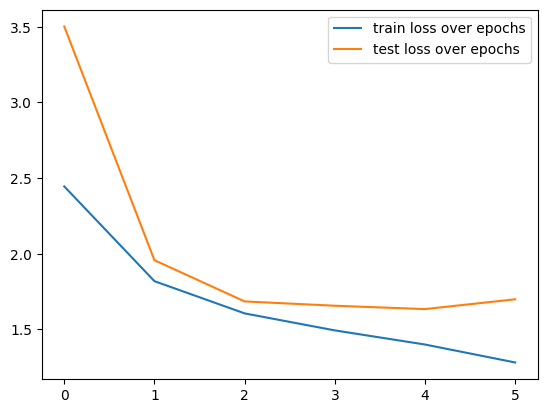

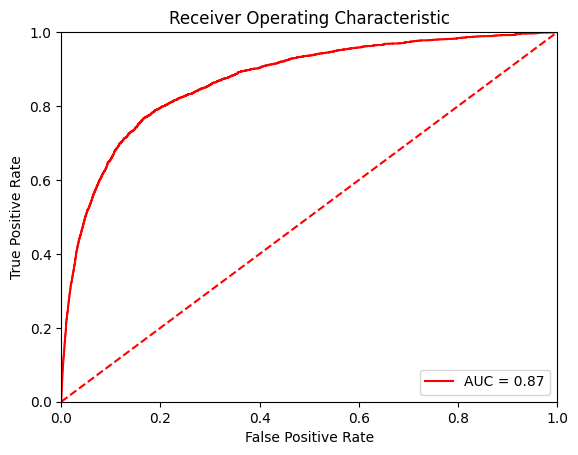

In [2]:
Xs_train_apo, Ys_train_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

baseline_model = baseline_utils.CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=baseline_model.parameters(),
                            lr=0.0001)


baseline_utils.train(baseline_model, optimizer, epochs=6, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo, save_aucroc_auprc_to='baseline-model')


In [ ]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/baseline-model.pt'
torch.save(baseline_model, OUTPUT_PATH)
# Epoch: 5 | Loss: 1.20505, Accuracy: 93.12% | Test loss: 1.69940, AUC: 0.8711, MCC: 0.3946, F1: 0.9331, AUPRC: 0.3815, sum: 3549.0


## Determine decision threshold
Check which threshold is optimal to decide between 0 and 1 labels.

In [10]:
import os
import numpy as np
from sklearn import metrics


X, labels, = test_dataset_apo[:]
X = X.to(device)

thresholds = np.arange(0.0, 1.0, 0.05)
for threshold in thresholds:
    predictions = baseline_model(X).squeeze()
    rounded_predictions = (predictions > threshold).cpu().numpy().astype(int)
    acc = metrics.accuracy_score(labels, rounded_predictions)

    mcc = metrics.matthews_corrcoef(labels, rounded_predictions)
    f1 = metrics.f1_score(labels, rounded_predictions, average='weighted')

    print(f"Threshold: {threshold:.2f} | Accuracy: {acc:.4f} | MCC: {mcc:.4f} | F1: {f1:.4f}")

Threshold: 0.00 | Accuracy: 0.6699 | MCC: 0.2527 | F1: 0.7581
Threshold: 0.05 | Accuracy: 0.6749 | MCC: 0.2540 | F1: 0.7619
Threshold: 0.10 | Accuracy: 0.6807 | MCC: 0.2561 | F1: 0.7662
Threshold: 0.15 | Accuracy: 0.6843 | MCC: 0.2558 | F1: 0.7689
Threshold: 0.20 | Accuracy: 0.6895 | MCC: 0.2613 | F1: 0.7728
Threshold: 0.25 | Accuracy: 0.6949 | MCC: 0.2615 | F1: 0.7768
Threshold: 0.30 | Accuracy: 0.6993 | MCC: 0.2629 | F1: 0.7800
Threshold: 0.35 | Accuracy: 0.7060 | MCC: 0.2685 | F1: 0.7849
Threshold: 0.40 | Accuracy: 0.7093 | MCC: 0.2680 | F1: 0.7873
Threshold: 0.45 | Accuracy: 0.7147 | MCC: 0.2714 | F1: 0.7913
Threshold: 0.50 | Accuracy: 0.7194 | MCC: 0.2733 | F1: 0.7946
Threshold: 0.55 | Accuracy: 0.7242 | MCC: 0.2759 | F1: 0.7981
Threshold: 0.60 | Accuracy: 0.7299 | MCC: 0.2791 | F1: 0.8022
Threshold: 0.65 | Accuracy: 0.7330 | MCC: 0.2805 | F1: 0.8043
Threshold: 0.70 | Accuracy: 0.7369 | MCC: 0.2823 | F1: 0.8071
Threshold: 0.75 | Accuracy: 0.7426 | MCC: 0.2874 | F1: 0.8111
Threshol

## Finetuning ESM2 model
Let's move away from transfer learning and let's finetune the whole ESM2 model.

In [2]:
from transformers import EsmModel, AutoTokenizer
import torch
import torch.nn as nn
import numpy as np
import csv
from datasets import Dataset
import functools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import gc
import bitsandbytes as bnb
from torch.utils.data import DataLoader
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(42)
MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'


In [3]:
finetuned_model = finetuning_utils.FinetunedEsmModel(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:

            output = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output = finetuned_model(batch)

        labels = batch['labels'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        loss =  loss_fn(cbs_logits, valid_flattened_labels)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 1.06527, Accuracy: 19.73% | Test loss: 1.01993, AUC: 0.4925, MCC: -0.0238, F1: 0.2646, AUPRC: 0.0602, sum: 46510
Epoch: 1 | Loss: 0.73219, Accuracy: 88.71% | Test loss: 0.81390, AUC: 0.8115, MCC: 0.2690, F1: 0.9028, AUPRC: 0.2190, sum: 5926
Epoch: 2 | Loss: 0.67687, Accuracy: 89.69% | Test loss: 0.75158, AUC: 0.8333, MCC: 0.3012, F1: 0.9097, AUPRC: 0.2508, sum: 5515


In [ ]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/base-finetuned-model.pt'
torch.save(finetuned_model, OUTPUT_PATH)

## Multitask learning with ESM2 finetuning
Take the ESM2 model and finetune it on the CryptoBench dataset. Create a second task for predicting residue flexibility. The flexibility is represented by two features: apo-holo distance and pLDDT. pLDDT values were extracted from the AlphaFold database.

In [5]:
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'

In [6]:
torch.manual_seed(42)

finetuned_model = finetuning_utils.MultitaskFinetunedEsmModel(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, distances_scaler=distances_scaler, distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, output3 = finetuned_model(batch)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  distance_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + distances_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 0.85853, Accuracy: 19.73% | Test loss: 1.01993, AUC: 0.4925, MCC: -0.0238, F1: 0.2646, AUPRC: 0.0602, sum: 46510
Epoch: 1 | Loss: 0.79319, Accuracy: 89.77% | Test loss: 0.80838, AUC: 0.8111, MCC: 0.2664, F1: 0.9087, AUPRC: 0.2198, sum: 5083
Epoch: 2 | Loss: 0.41769, Accuracy: 87.89% | Test loss: 0.75483, AUC: 0.8315, MCC: 0.2976, F1: 0.8991, AUPRC: 0.2469, sum: 6874


In [7]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model.pt'
torch.save(finetuned_model, OUTPUT_PATH)
# Epoch: 3 | Loss: 0.62206, Accuracy: 89.31% | Test loss: 0.56235, AUC: 0.8885, MCC: 0.4261, F1: 0.9122, AUPRC: 0.4397, sum: 7320

## Multitask learning + ESM2 finetuning with additional data
Leverage LIGYSIS dataset to obtain more data. Although binding sites in general can be of different nature than cryptic binding sites, use the general BS dataset to pre-finetune the model before applying CryptoBench dataset.

In [ ]:
finetuned_model = finetuning_utils.MultitaskFinetunedEsmModel(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

plDDT_path = '/home/skrhakv/cryptic-nn/data/ligysis/plDDT'
plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', plDDT_path=plDDT_path, uniprot_ids=True)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, uniprot_ids=True)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 4

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss
            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


## LOAD CRYPTOBENCH DATASET
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, distances_scaler=distances_scaler, distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 4

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

# similarly train only the classifier for the first few epochs 
for name, param in finetuned_model.named_parameters():
     if name.startswith('llm') or name.startswith('classifier') or name.startswith('plDDT'):
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, output3 = finetuned_model(batch)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  distance_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + distances_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 0.72350, Accuracy: 19.73% | Test loss: 1.01993, AUC: 0.4925, MCC: -0.0238, F1: 0.2646, AUPRC: 0.0602, sum: 46510
Epoch: 1 | Loss: 0.53515, Accuracy: 84.16% | Test loss: 0.78040, AUC: 0.8033, MCC: 0.2788, F1: 0.8760, AUPRC: 0.2328, sum: 9401
Epoch: 2 | Loss: 0.45756, Accuracy: 82.40% | Test loss: 0.75159, AUC: 0.8211, MCC: 0.2968, F1: 0.8654, AUPRC: 0.2677, sum: 10892
Epoch: 3 | Loss: 0.23589, Accuracy: 85.77% | Test loss: 0.59920, AUC: 0.8811, MCC: 0.3942, F1: 0.8892, AUPRC: 0.4188, sum: 9704
Epoch: 0 | Loss: 0.75070, Accuracy: 80.75% | Test loss: 0.65100, AUC: 0.8834, MCC: 0.3516, F1: 0.8559, AUPRC: 0.4417, sum: 12801
Epoch: 1 | Loss: 0.34551, Accuracy: 80.75% | Test loss: 0.65100, AUC: 0.8834, MCC: 0.3516, F1: 0.8559, AUPRC: 0.4417, sum: 12801
Epoch: 2 | Loss: 0.92496, Accuracy: 80.75% | Test loss: 0.65100, AUC: 0.8834, MCC: 0.3516, F1: 0.8559, AUPRC: 0.4417, sum: 12801
Epoch: 3 | Loss: 0.58936, Accuracy: 89.54% | Test loss: 0.71424, AUC: 0.8203, MCC: 0.3299, F1: 0.9

In [ ]:
with torch.no_grad():
    for batch in val_dataloader:
        output1, _, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

        cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

        test_loss = cbs_test_loss

        test_losses.append(test_loss.cpu().float().detach().numpy())

        # compute metrics on test dataset
        test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                y_pred=predictions)
        fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

        f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

        precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        auprc = metrics.auc(recall, precision)

        del labels, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


Epoch: 3 | Loss: 0.58936, Accuracy: 90.46% | Test loss: 0.53808, AUC: 0.8962, MCC: 0.4513, F1: 0.9200, AUPRC: 0.4911, sum: 6682


In [8]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model-with-ligysis.pt'
torch.save(finetuned_model, OUTPUT_PATH)
# Epoch: 3 | Loss: 0.58936, Accuracy: 90.46% | Test loss: 0.53808, AUC: 0.8962, MCC: 0.4513, F1: 0.9200, AUPRC: 0.4911, sum: 6682

In [3]:
finetuned_model = finetuning_utils.MultitaskFinetunedEsmModelWithCnn(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

plDDT_path = '/home/skrhakv/cryptic-nn/data/ligysis/plDDT'
plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', plDDT_path=plDDT_path, uniprot_ids=True)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, uniprot_ids=True)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT', plDDT_scaler=plDDT_scaler)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


## LOAD CRYPTOBENCH DATASET
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, distances_scaler=distances_scaler, distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, plDDT_path=plDDT_path, plDDT_scaler=plDDT_scaler)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

# similarly train only the classifier for the first few epochs 
for name, param in finetuned_model.named_parameters():
     if name.startswith('llm') or name.startswith('classifier') or name.startswith('plDDT'):
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, output3 = finetuned_model(batch)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  distance_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + distances_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 0.49651, Accuracy: 39.79% | Test loss: 1.02308, AUC: 0.4758, MCC: -0.0238, F1: 0.5229, AUPRC: 0.0548, sum: 33851
Epoch: 1 | Loss: 1.12666, Accuracy: 81.53% | Test loss: 0.80564, AUC: 0.7875, MCC: 0.2605, F1: 0.8590, AUPRC: 0.2241, sum: 11036
Epoch: 2 | Loss: 1.04292, Accuracy: 80.17% | Test loss: 0.78241, AUC: 0.7988, MCC: 0.2697, F1: 0.8505, AUPRC: 0.2458, sum: 12104
Epoch: 0 | Loss: 0.38424, Accuracy: 82.35% | Test loss: 0.65458, AUC: 0.8664, MCC: 0.3498, F1: 0.8663, AUPRC: 0.4043, sum: 11635
Epoch: 1 | Loss: 0.96531, Accuracy: 83.12% | Test loss: 0.63284, AUC: 0.8744, MCC: 0.3625, F1: 0.8715, AUPRC: 0.4228, sum: 11249
Epoch: 2 | Loss: 1.30842, Accuracy: 84.64% | Test loss: 0.62540, AUC: 0.8689, MCC: 0.3709, F1: 0.8814, AUPRC: 0.4129, sum: 10241


In [5]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model-with-CNN-with-ligysis.pt'
torch.save(finetuned_model, OUTPUT_PATH)
# Epoch: 3 | Loss: 0.24617, Accuracy: 91.82% | Test loss: 0.61883, AUC: 0.8808, MCC: 0.4516, F1: 0.9283, AUPRC: 0.4573, sum: 5471
